# Seminar - Building graph dataset from logs


In this part of the seminar, we will observe how to build a graph based on the given tabular data

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

In [3]:
road_segments_df = pd.read_csv("./road_segments_df.csv", index_col=0)
road_segments_df.head()

,road_id,source,target,num_feature_0,cat_feature_0,num_feature_1,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,4008796249405499054,205211928,1843134,40.200001,2.0,1,True,False,False,False,False,False,False,False,True,True,False
1,13253002403661002048,205211928,205211929,155.500000,2.0,1,True,False,False,False,False,False,False,False,True,True,False
2,7819383735317862381,205211928,205211930,15.700000,2.0,1,True,False,False,False,False,False,False,False,True,True,False
3,8193759533638839121,205211928,205211931,78.400002,2.0,1,True,False,False,False,False,False,False,False,True,True,False
4,5445526263395718932,205211929,205211928,155.500000,2.0,1,True,False,False,False,False,False,False,False,True,True,False


#### What this table actually represents:
Traffic network can be represented in multiple ways. In this scenario, we build it on roads - each road has starts and ends *somewhere*. For us *somewhere* is a specific place on a map - on a crossing.
In this dataframe we don't have target column (which we wanna predict), but youl have it in the homework, don't worry ;)

#### What these columns actually mean:
- `road_id` - id of a road/track
- `source` - crossing id where the road starts
- `target` - crossing id where the road ends
- `length` - length of a road
- and some features (won't be used here)

#### How can we build a graph?

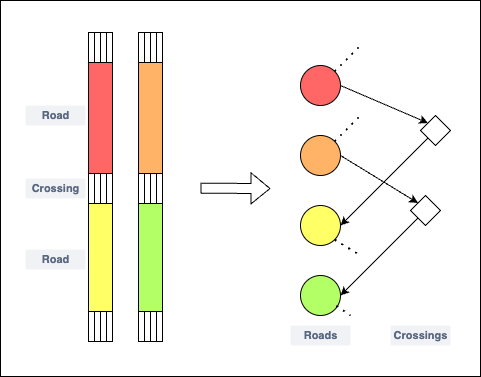

In [4]:
unique_road_ids = set(road_segments_df["road_id"].unique().tolist())

print(f"Number of unique road_ids (nodes) = {len(unique_road_ids)/1e6:.3f}K")

Number of unique road_ids (nodes) = 0.671K


Swap irregular `road_id` with ordered regular int32 `node_id`, based on the row number:

In [5]:
road_segments_df = road_segments_df.reset_index().rename({"index": "node_idx"}, axis="columns")
road_segments_df.head()

,node_idx,road_id,source,target,num_feature_0,cat_feature_0,num_feature_1,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,0,4008796249405499054,205211928,1843134,40.200001,2.0,1,True,False,False,False,False,False,False,False,True,True,False
1,1,13253002403661002048,205211928,205211929,155.500000,2.0,1,True,False,False,False,False,False,False,False,True,True,False
2,2,7819383735317862381,205211928,205211930,15.700000,2.0,1,True,False,False,False,False,False,False,False,True,True,False
3,3,8193759533638839121,205211928,205211931,78.400002,2.0,1,True,False,False,False,False,False,False,False,True,True,False
4,4,5445526263395718932,205211929,205211928,155.500000,2.0,1,True,False,False,False,False,False,False,False,True,True,False


### 

Additionally, encode `source` and `target` into regular ids:

In [6]:
# e.g. with this code:
crossing_ids = set(road_segments_df["source"].values.tolist()) | set(road_segments_df["target"].values.tolist())
print(f"Number of unique crossings (road endpoints) = {len(crossing_ids)/1e6:.3f}K")


crossing_id_to_index_mapping = dict(map(reversed, enumerate(crossing_ids)))  # crossind_id --> index
crossing_index_to_id_mapping = dict(enumerate(crossing_ids))                 # index --> crossing_id

Number of unique crossings (road endpoints) = 0.314K


In [7]:
# crossing_id_to_index_mapping

In [9]:
road_segments_df["source_idx"] = road_segments_df["source"].map(crossing_id_to_index_mapping)
road_segments_df["target_idx"] = road_segments_df["target"].map(crossing_id_to_index_mapping)
road_segments_df.head()

,node_idx,road_id,source,target,num_feature_0,cat_feature_0,num_feature_1,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,source_idx,target_idx
0,0,4008796249405499054,205211928,1843134,40.200001,2.0,1,True,False,False,False,False,False,False,False,True,True,False,281535,302104
1,1,13253002403661002048,205211928,205211929,155.500000,2.0,1,True,False,False,False,False,False,False,False,True,True,False,281535,281536
2,2,7819383735317862381,205211928,205211930,15.700000,2.0,1,True,False,False,False,False,False,False,False,True,True,False,281535,281537
3,3,8193759533638839121,205211928,205211931,78.400002,2.0,1,True,False,False,False,False,False,False,False,True,True,False,281535,281538
4,4,5445526263395718932,205211929,205211928,155.500000,2.0,1,True,False,False,False,False,False,False,False,True,True,False,281536,281535


### Obtaining adjacency



`road_idx` $i$ is connected to `road_idx` $j$ $\iff  \text{target\_idx}_i = \text{source\_idx}_j = \text{crossing }k$. That's the condition where we can ride road $i$ and get to road $j$ through the crossing $k$.

In [10]:
road_segments_truncated = road_segments_df.loc[:, ["node_idx", "source_idx", "target_idx"]]
road_segments_truncated.head()

,node_idx,source_idx,target_idx
0,0,281535,302104
1,1,281535,281536
2,2,281535,281537
3,3,281535,281538
4,4,281536,281535


In [11]:
road_segments_connected_by_crossings_df = road_segments_truncated.merge(
    road_segments_truncated,
    left_on="target_idx",
    right_on="source_idx",
    suffixes=["__source", "__target"]
)

road_segments_connected_by_crossings_df

,node_idx__source,source_idx__source,target_idx__source,node_idx__target,source_idx__target,target_idx__target
0,0,281535,302104,337924,302104,302103
1,0,281535,302104,337925,302104,281535
2,337922,302103,302104,337924,302104,302103
3,337922,302103,302104,337925,302104,281535
4,1,281535,281536,4,281536,281535
...,...,...,...,...,...,...
1610904,670836,16542,16543,670837,16543,16548
1610905,670838,16544,16545,670839,16545,16548
1610906,670840,16546,16547,670841,16547,16548
1610907,670842,16548,12281,380034,12281,12280


In [12]:
edges_df = road_segments_connected_by_crossings_df.loc[:, ["node_idx__source", "node_idx__target"]]
edges_df

,node_idx__source,node_idx__target
0,0,337924
1,0,337925
2,337922,337924
3,337922,337925
4,1,4
...,...,...
1610904,670836,670837
1610905,670838,670839
1610906,670840,670841
1610907,670842,380034


In [14]:
edge_list = edges_df.values
edge_list

array([[     0, 337924],
       [     0, 337925],
       [337922, 337924],
       ...,
       [670840, 670841],
       [670842, 380034],
       [670844, 670843]])

#### Equivalently, we can use sparse-sparse matrix multiplication to obtain adjacency

which is algorithmically the same, but technically different:

In [15]:
road_to_target_pairs = road_segments_df[['node_idx', 'target_idx']].values
source_to_road_pairs = road_segments_df[['node_idx', 'source_idx']].values

In [17]:
num_crossings = len(crossing_id_to_index_mapping)
num_roads = road_segments_df["node_idx"].nunique()
num_crossings, num_roads

(313967, 670845)

In [20]:
rows, cols = road_to_target_pairs.T
values = np.ones(shape=(len(rows),))

data = (values, (rows, cols))
road_to_target_incidence_matrix = sp.coo_matrix(data, shape=(num_roads, num_crossings))
road_to_target_incidence_matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 670845 stored elements and shape (670845, 313967)>

In [21]:
rows, cols = source_to_road_pairs.T
values = np.ones(shape=(len(rows),))

data = (values, (cols, rows))
source_to_road_incidence_matrix = sp.coo_matrix(data, shape=(num_crossings, num_roads))
source_to_road_incidence_matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 670845 stored elements and shape (313967, 670845)>

In [22]:
road_adjacency_matrix = road_to_target_incidence_matrix @ source_to_road_incidence_matrix
road_adjacency_matrix = road_adjacency_matrix.tocoo()
road_adjacency_matrix

<COOrdinate sparse matrix of dtype 'float64'
	with 1610909 stored elements and shape (670845, 670845)>

In [23]:
edge_list_from_sparse = np.stack(road_adjacency_matrix.nonzero()).T
edge_list_from_sparse

array([[     0, 337925],
       [     0, 337924],
       [     1,      4],
       ...,
       [670842, 380034],
       [670843, 670842],
       [670844, 670843]], dtype=int32)

[SANITY CHECK] Let's compare the results:

In [24]:
# make edge lists comparable:
edge_list_from_pandas_sorted = set(map(tuple, edge_list.tolist()))
edge_list_from_scipy_sorted = set(map(tuple, edge_list_from_sparse.tolist()))

# compare edge lists:
assert edge_list_from_pandas_sorted == edge_list_from_scipy_sorted